# Diabetes Prediction - Machine Learning Project

In this project, we aim to analyze and build machine learning models to predict whether a person has diabetes based on various medical measurements.
The dataset used is the Pima Indians Diabetes Dataset.


### Importing requiered libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,  roc_curve,  RocCurveDisplay, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Initial Data Exploration

Let's take a first look at the dataset to understand its structure, including:
- Sample records (first few rows)
- Number of rows and columns
- Column names and data types


In [5]:
df = pd.read_csv("D:/new start/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.shape

(768, 9)

In [7]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

###  Data Cleaning

Before building any models, we need to clean the dataset to ensure its qualit
We will check for null values and duplicates 

Then, 

Some columns contain zero values which are not medically valid, such as:
- Glucose
- BloodPressure
- SkinThickness
- Insuli
- BMI

We will identify how many zero values exist in each of these columns and decide how to handle them (either by replacing them with more appropriate values or removing the affected rows).


In [9]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.duplicated().any()

False

In [11]:
col_with_zeros = ['Glucose','Insulin', 'BMI', 'BloodPressure', 'SkinThickness']
for col in col_with_zeros:
    zero_count = (df[col] == 0).sum()
    print(f"{col} has {zero_count} zeros")

Glucose has 5 zeros
Insulin has 374 zeros
BMI has 11 zeros
BloodPressure has 35 zeros
SkinThickness has 227 zeros


In [12]:
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0 with NaN
for col in cols_with_invalid_zeros:
    df[col] = df[col].replace(0, np.nan)


In [13]:
mice_imputer = IterativeImputer(random_state=42)

df_imputed = df.copy()
df_imputed.iloc[:, :-1] = mice_imputer.fit_transform(df_imputed.iloc[:, :-1])

### Missing Values Imputation using MICE

In the dataset, several features contained invalid zero values which are not plausible for medical data, such as:

- Glucose  
- BloodPressure  
- SkinThickness  
- Insulin  
- BMI  

These zero values were replaced with `NaN` and then handled using the **MICE (Multiple Imputation by Chained Equations)** technique via `IterativeImputer`.

#### Why MICE?

MICE is a smart and powerful method for missing data imputation. Instead of simply filling missing values with the mean or median, it:

- Builds a regression model for each missing feature based on the others  
- Iteratively predicts and updates the missing values  
- Preserves the complex relationships between features  

This approach helps the machine learning models learn from more realistic and coherent data patterns, improving the chances of accurate predictions.

MICE was chosen over simple imputation methods to enhance model quality and reflect real-world data distributions.
d data distributions.
ld data distributions.
modeling.

## Data Preparation

Before training any machine learning models, we need to separate the dataset into:

- **Features (X)**: all input columns that will be used to make predictions.
- **Target (y)**: the output column we want to predict — in this case, whether a person has diabetes (`Outcome` column).

This step helps us clearly define what the model will learn from, and what it should try to predict.


In [16]:
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

### Train/Test Split

We split the data into training and testing sets:

- 80% for training the model
- 20% for testing the model's performance

This helps us evaluate how well the model generalizes to unseen data.


In [18]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

We applied Standard Scaling to the features so that all variables have a mean of 0 and a standard deviation of 1. This ensures that models like Logistic Regression or KNN are not biased due to differing feature scales.


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model 1: Logistic Regression

We started with Logistic Regression as a simple baseline model.

The model was trained on the scaled training data and evaluated on the test data using accuracy, confusion matrix, and classification metrics.

In [22]:
# Initialize the model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7532467532467533
Confusion Matrix:
 [[82 17]
 [21 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



### ROC Curve

To evaluate the model's ability to distinguish between the two classes (diabetic vs non-diabetic), we plotted the ROC (Receiver Operating Characteristic) curve.

The ROC curve shows the trade-off between the True Positive Rate (Recall) and the False Positive Rate at various threshold settings.

We also calculated the AUC (Area Under the Curve), which gives a single score representing the overall performance of the model. The closer the AUC is to 1, the better the model's ability to classify correctly.


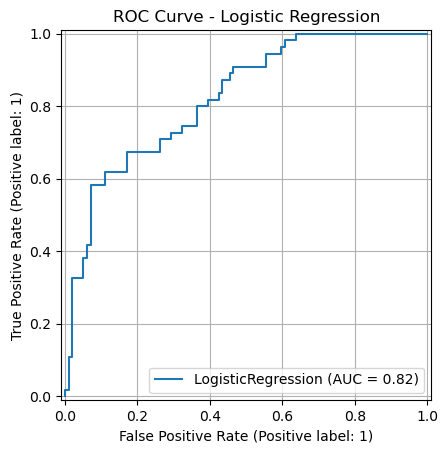

In [24]:
# Plot ROC curve
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()

## Model 1: Logistic Regression

We started with Logistic Regression as a simple and interpretable baseline model for binary classification.

### Why Logistic Regression?

- It's easy to implement and fast to train.
- Provides probability scores using the sigmoid function.
- Outputs can be easily evaluated and thresholds adjusted for sensitivity.

###  Model Training:

- The model was trained on the scaled training set using `StandardScaler`.
- We used `LogisticRegression` from `sklearn.linear_model`.

### Evaluation Results:

- **Accuracy**: 0.75 
- **Precision**: 0.67
- **Recall**: 0.62
- **F1 Score**: 0.64  
- **ROC AUC**: 0.82
### Confusion Matrix:

- **82** True Negatives
- **34** True Positives
- **17** False Positives
- **21** False Negatives

### ROC Curve:

The ROC Curve was plotted to assess the model's ability to distinguish between classes at various thresholds.  
The curve showed a strong AUC of **0.82**, indicating good overall performance.

> Logistic Regression performed reasonably well but showed room for improvement, especially in recall (sensitivity), which motivated us to explore more complex models like Random Forest.


### Model 2: Random Forest Classifier

In this section, we will apply a Random Forest Classifier to improve upon the baseline Logistic Regression model.

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the class that is the majority vote of the trees. It is known for its robustness, ability to handle complex data patterns, and resistance to overfitting.

We will train this model on the same dataset and evaluate its performance using accuracy, confusion matrix, precision, recall, F1-score, and ROC AUC.


In [27]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1] 

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.7207792207792207

Confusion Matrix:
 [[75 24]
 [19 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        99
           1       0.60      0.65      0.63        55

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



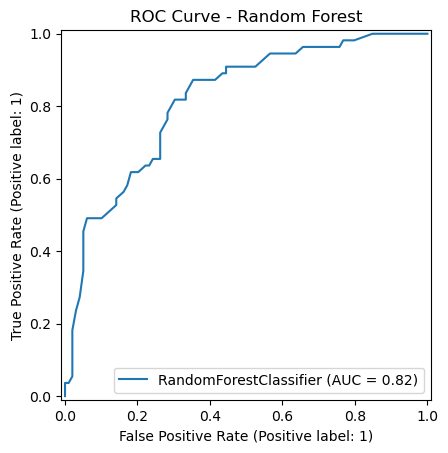

In [28]:
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

### Random Forest Classifier

To improve the performance of our baseline Logistic Regression model, we trained a **Random Forest Classifier** as an alternative.

Random Forest is an ensemble learning method that builds multiple decision trees and merges their outputs to provide more accurate and stable predictions.

#### Model Training

- Model: `RandomForestClassifier` from `sklearn.ensemble`
- No hyperparameter tuning applied at this stage (default settings)
- Trained on the same training set used with logistic regression

#### Evaluation Results on Test Set:
- **Accuracy**: 0.72  
- **Precision**: 0.60  
- **Recall**: 0.65
- **F1 Score**: 0.63 
- **ROC AUC**: 0.82


#### Confusion Matrix:

- 75: True Negatives (correctly predicted non-diabetic)
- 36: True Positives (correctly predicted diabetic)
- 24: False Positives (predicted diabetic but actually non-diabetic)
- 19: False Negatives (predicted non-diabetic but actually diabetic)

#### ROC Curve:

The ROC Curve illustrates the trade-off between the true positive rate and false positive rate at different classification thresholds.

The model achieved an AUC of **0.82**, which indicates a good ability to distinguish between diabetic and non-diabetic patients.


### Why Random Forest?

- Handles non-linear relationships effectively  
- Robust to outliers and missing values  
- Doesn't require feature scaling  
- Reduces the risk of overfitting compared to a single decision tree

> Random Forest slightly improved **Recall** but had a lower **Precision** than Logistic Regression. Further tuning might be needed to boost its overall performance.


In [30]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.7207792207792207

Confusion Matrix:
 [[72 27]
 [16 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77        99
           1       0.59      0.71      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154



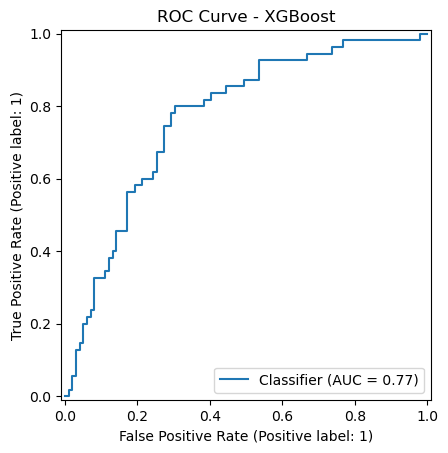

In [32]:
RocCurveDisplay.from_predictions(y_test, y_prob_xgb)
plt.title("ROC Curve - XGBoost")
plt.show()

### Model 3: XGBoost Classifier

We trained an XGBoost Classifier on the dataset without applying feature scaling, as tree-based models are not sensitive to the scale of input features.

The model was evaluated using accuracy, confusion matrix, classification metrics, and the ROC AUC score.

**Performance Summary:**

- **Accuracy**: 0.72  
- **Precision**: 0.59  
- **Recall**: 0.71  
- **F1 Score**: 0.64  
- **ROC AUC**: 0.77

**Confusion Matrix**:
    
72: True Negatives (correctly predicted non-diabetic)

39: True Positives (correctly predicted diabetic)

27: False Positives (predicted diabetic but actually non-diabetic)

16: False Negatives (predicted non-diabetic but actually diabetic)

**ROC Curve**:
    
The ROC Curve illustrates the trade-off between the true positive rate and false positive rate at different classification thresholds.
The XGBoost model achieved an AUC of 0.77, which reflects a reasonable ability to distinguish between diabetic and non-diabetic patients.


**Why XGBoost?**

XGBoost was chosen for its high performance and flexibility. It builds trees sequentially to correct previous errors (gradient boosting), handles missing values automatically, and includes regularization to reduce overfitting.
It often outperforms other models on structured data, making it a strong choice after testing simpler models.


>XGBoost performed slightly better than logistic regression in terms of recall, capturing more true positives. However, it had lower precision, meaning more false positives. This makes it a good choice when minimizing false negatives (missing actual diabetic cases) is important.


# Comparing 3 models

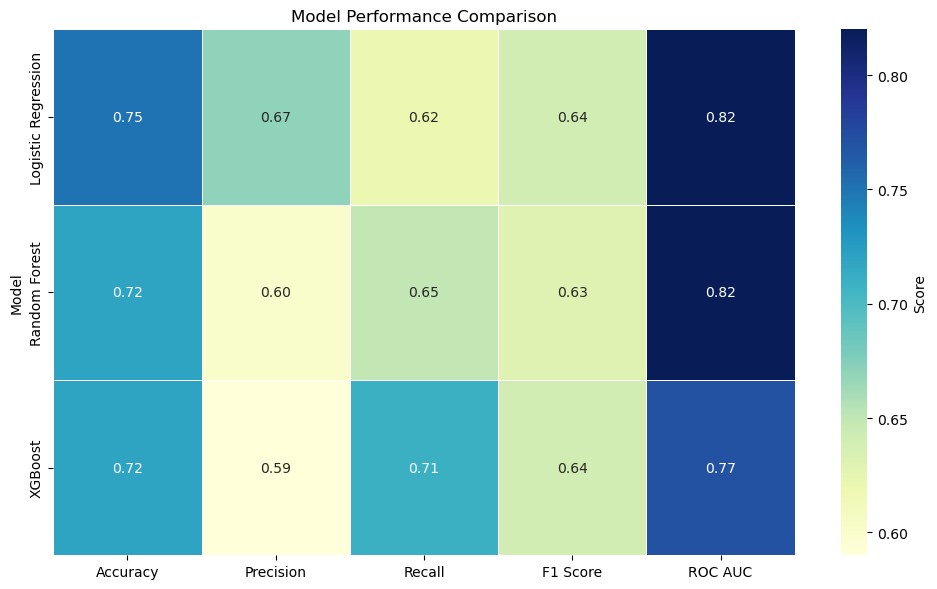

In [35]:
# Performance metrics for each model
data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [0.75, 0.72, 0.72],
    "Precision": [0.67, 0.60, 0.59],
    "Recall": [0.62, 0.65, 0.71],
    "F1 Score": [0.64, 0.63, 0.64],
    "ROC AUC": [0.82, 0.82, 0.77]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)
df_metrics.set_index("Model", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Score'})
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()

## Model Tuning: Logistic Regression with GridSearchCV


In [70]:
# 1. Define the base model
log_reg = LogisticRegression(max_iter=1000)

# 2. Define parameter grid
param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
}

# 3. GridSearchCV setup
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 4. Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# 5. Best results
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC AUC Score: 0.8388212303296282


In [72]:
# Build model with best params
final_model = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000
)

# Fit on training data
final_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]
# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7597402597402597
Confusion Matrix:
 [[83 16]
 [21 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



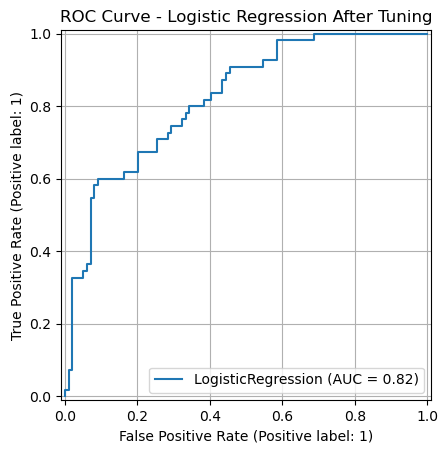

In [82]:
# Plot ROC curve
RocCurveDisplay.from_estimator(final_model, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression After Tuning")
plt.grid(True)
plt.show()


After training the initial Logistic Regression model, we performed hyperparameter tuning using GridSearchCV to find the best combination of:

Regularization strength C

Type of penalty (l2)

Solver algorithm (lbfgs)

The model was optimized based on ROC AUC Score, and the best parameters were:

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC AUC Score: 0.8388
This helped improve the model’s ability to separate diabetic from non-diabetic cases.

Next, we will explore threshold tuning to further improve Recall, especially for identifying diabetic patients.


In [116]:
# Get predicted probabilities for the positive class (1)
y_probs = final_model.predict_proba(X_test_scaled)[:, 1]

# Try different thresholds and check precision & recall
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    
    print(f"Threshold: {thresh:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f}")


Threshold: 0.30 | Precision: 0.57 | Recall: 0.78
Threshold: 0.35 | Precision: 0.59 | Recall: 0.73
Threshold: 0.40 | Precision: 0.61 | Recall: 0.71
Threshold: 0.45 | Precision: 0.64 | Recall: 0.67
Threshold: 0.50 | Precision: 0.68 | Recall: 0.62
Threshold: 0.55 | Precision: 0.77 | Recall: 0.60
Threshold: 0.60 | Precision: 0.80 | Recall: 0.58
Threshold: 0.65 | Precision: 0.81 | Recall: 0.53


### Threshold Tuning for Logistic Regression
To further improve the model's performance, especially in detecting diabetic cases, we manually tuned the classification threshold instead of sticking to the default 0.5.

Different thresholds produce different balances between Precision and Recall.

We selected threshold = 0.40 as the optimal value because it provides a recall of 0.71, which is important for capturing diabetic patients, while maintaining a decent precision of 0.61 to reduce false positives.


 This threshold was used to re-calculate model metrics and improve sensitivity to the positive class.

In [121]:
# Set a custom classification threshold
chosen_threshold = 0.40

# Apply the threshold to predicted probabilities
y_pred_threshold = (y_probs >= chosen_threshold).astype(int)

# Evaluate model performance with the new threshold
print(confusion_matrix(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))


[[74 25]
 [16 39]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        99
           1       0.61      0.71      0.66        55

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



## Final Model Evaluation after Threshold Tuning
After selecting a custom threshold = 0.40, the Logistic Regression model was re-evaluated to balance precision and recall more effectively:
- **Accuracy**: 0.73
- **Precision**: 0.61
- **Recall**: 0.71
- **F1-Score**: 0.66

Confusion Matrix:
- **74** True Negatives
- **39** True Positives
- **25** False Positives
- **16** False Negatives


This threshold offered a good trade-off:

Captures more diabetic cases (recall↑)

Keeps false positives at a reasonable level (precision↑ compared to lower thresholds)



## Model Tuning: Random Forest with GridSearchCV


In [129]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees in the forest
    'max_depth': [5, 10, None],                # Maximum depth of the tree
    'min_samples_split': [2, 5],               # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],                # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']           # Number of features to consider at each split
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Use the best model found by GridSearch
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test)
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", best_rf_model.score(X_test, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_probs))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC AUC Score: 0.8488120531014587
Accuracy: 0.7337662337662337
Confusion Matrix:
 [[77 22]
 [19 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79        99
           1       0.62      0.65      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.74       154

AUC: 0.8369146005509641


### Model Tuning: Random Forest Classifier

After evaluating the default Random Forest model, we applied hyperparameter tuning using `GridSearchCV` to explore different parameter combinations and enhance performance.

#### Grid Search Parameters:

- `n_estimators`: [100, 200, 300]  
- `max_depth`: [5, 10, None]  
- `min_samples_split`: [2, 5]  
- `min_samples_leaf`: [1, 2]  
- `max_features`: ['sqrt', 'log2']  

The grid search used 5-fold cross-validation and was optimized for the **ROC AUC score**.

#### Best Parameters:


    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2'

###  Evaluation Results (After Tuning)

- **Accuracy**: 0.734  
- **Precision (Diabetic class)**: 0.62  
- **Recall (Diabetic class)**: 0.65  
- **F1 Score (Diabetic class)**: 0.64  
- **ROC AUC**: 0.837

#### Confusion Matrix:

- 77 → True Negatives (non-diabetic correctly predicted)  
- 36 → True Positives (diabetic correctly predicted)  
- 22 → False Positives (predicted diabetic but actually not)  
- 19 → False Negatives (predicted non-diabetic but actually diabetic)


## Model Tuning: XGBOOST Classifier


In [136]:
# Initialize model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Use best estimator
final_xgb = grid_search.best_estimator_

# Predict
y_pred = final_xgb.predict(X_test)
y_probs = final_xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_probs))


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best ROC AUC Score: 0.8534284039484298
Accuracy: 0.7467532467532467
Confusion Matrix:
 [[79 20]
 [19 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80        99
           1       0.64      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

AUC: 0.8325068870523415


### Model 4: XGBoost Classifier (After Hyperparameter Tuning)

We used XGBoost to train a powerful and flexible classification model. After extensive tuning using GridSearchCV, we found an optimal set of parameters that improved the model's performance.

**Why XGBoost?**  
XGBoost is an ensemble model based on gradient boosting. It often outperforms individual models because it builds multiple weak learners sequentially, correcting errors along the way. It also supports regularization to prevent overfitting and is known for its speed and scalability.

**Best Hyperparameters (via Grid Search):**  
- `n_estimators`: 200  
- `learning_rate`: 0.01  
- `max_depth`: 3  
- `subsample`: 0.8  
- `colsample_bytree`: 0.8  
- `reg_alpha`: 0  
- `reg_lambda`: 1  

**Evaluation Results on Test Set:**  
- Accuracy: 0.75  
- Precision: 0.64  
- Recall: 0.65  
- F1 Score: 0.65  
- ROC AUC Score: 0.83  

**Confusion Matrix Interpretation:**  
- 79: True Negatives (correctly predicted non-diabetic)  
- 36: True Positives (correctly predicted diabetic)  
- 20: False Positives (predicted diabetic but actually non-diabetic)  
- 19: False Negatives (predicted non-diabetic but actually diabetic)  

**ROC Curve Summary:**  
The ROC curve shows a good trade-off between sensitivity and specificity. The model achieved an AUC of 0.83, indicating strong classification ability.


# Comparing Models

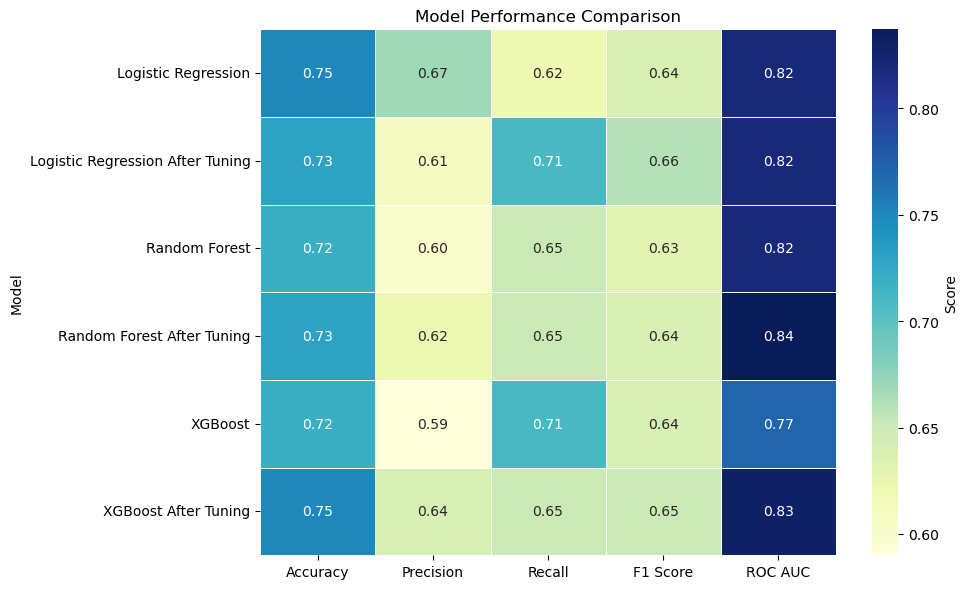

In [140]:
# Performance metrics for each model
data = {
    "Model": ["Logistic Regression","Logistic Regression After Tuning" ,"Random Forest","Random Forest After Tuning", "XGBoost","XGBoost After Tuning"],
    "Accuracy": [0.75, 0.73, 0.72, 0.73, 0.72, 0.75],
    "Precision": [0.67, 0.61, 0.60, 0.62, 0.59, 0.64],
    "Recall": [0.62, 0.71, 0.65, 0.65, 0.71, 0.65],
    "F1 Score": [0.64, 0.66, 0.63, 0.64, 0.64 ,0.65],
    "ROC AUC": [0.82, 0.82, 0.82, 0.837, 0.77, 0.83]
}
# Create DataFrame
df_metrics = pd.DataFrame(data)
df_metrics.set_index("Model", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Score'})
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()

### Final Model Comparison

The heatmap above compares the performance of all models across five key metrics: Accuracy, Precision, Recall, F1 Score, and ROC AUC.

- **Logistic Regression After Tuning** achieved the highest recall (0.71), making it suitable if detecting diabetic cases is the top priority.
- **XGBoost After Tuning** provided the best overall balance with high accuracy (0.75) and the highest ROC AUC (0.83), indicating strong classification ability.
- **Random Forest After Tuning** also performed well, especially in terms of AUC (0.837), and is a good candidate when interpretability is important.

Depending on the project goal (e.g. reducing false negatives), one can prioritize recall or AUC when choosing the final model.


## Conclusion

In this project, we analyzed a medical dataset to predict the likelihood of diabetes in patients using various classification models.

We started with a **baseline Logistic Regression** model, then explored more complex algorithms such as **Random Forest** and **XGBoost**. For each model, we applied hyperparameter tuning using **GridSearchCV** and evaluated performance based on multiple metrics including **Accuracy, Precision, Recall, F1 Score, and ROC AUC**.

The results showed that:

- **XGBoost After Tuning** achieved the best overall performance with an AUC of **0.83** and Accuracy of **0.75**.
- **Logistic Regression After Tuning** had the highest **Recall (0.71)**, which is important in medical settings where identifying positive cases is critical.
- **Random Forest After Tuning** also performed well, with a strong AUC of **0.837**, offering a good balance between complexity and interpretability.

Through this analysis, we demonstrated how model selection, evaluation, and hyperparameter tuning play a crucial role in building effective machine learning solutions, especially in healthcare applications.


This project highlights the importance of precision and recall trade-offs in medical predictions, and the value of interpretability and model evaluation in responsible AI development.
